In [2]:
from os import listdir
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import numpy as np
from IPython.display import Audio
import time
import random
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import pickle
from sklearn.metrics import accuracy_score, classification_report, accuracy_score

In [3]:
def data_load(path):
    audio_path = []
    audio_emotion = []
    directory_path = listdir(path)

    for audio in directory_path:
        audio_path.append(path+audio)
        emotion = audio.split("_")

        if emotion[2] == "ANG":
            audio_emotion.append("angry")
        elif emotion[2] == "FEA":
            audio_emotion.append("fear")
        elif emotion[2] == "DIS":
            audio_emotion.append("disgust")
        elif emotion[2] == "HAP":
            audio_emotion.append("happy")
        elif emotion[2] == "NEU":
            audio_emotion.append("neutral")
        elif emotion[2] == "SAD":
            audio_emotion.append("sad")

    emotion_dataset = pd.DataFrame(audio_emotion, columns=['Emotions'])
    audio_path_dataset = pd.DataFrame(audio_path, columns=['Path'])
    dataset = pd.concat([audio_path_dataset, emotion_dataset], axis= 1)

    return dataset

def waveplot(data,sr,emotion):
    plt.figure(figsize=(15,4), facecolor=(.9,.9,.9))
    plt.title(emotion, size=14)
    librosa.display.waveshow(data,sr=sr,color='pink')
    plt.show()

def spectogram_linear(data,sr,emotion):
    x = librosa.stft(data)
    # convert to db
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(15,4), facecolor=(.9,.9,.9))
    plt.title(emotion, size=14)
    librosa.display.specshow(xdb,sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format="%+2.f dB")

def spectogram_log(data,sr,emotion):
    x = librosa.stft(data)
    # convert to db
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(15,4), facecolor=(.9,.9,.9))
    plt.title(emotion, size=14)
    librosa.display.specshow(xdb,sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format="%+2.f dB")

def mfcc_feature(file):
    y,sr = librosa.load(file, duration=4, offset=0.5)
    n_fft = int(sr * 0.02)
    hop_length = n_fft // 2
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length).T, axis=0)

    return mfcc

In [4]:
dataset = data_load(path = "./dataset/")

In [5]:
dataset["Emotions"].value_counts()

angry      1271
disgust    1271
fear       1271
happy      1271
sad        1271
neutral    1087
Name: Emotions, dtype: int64

# Exploritory Data Analysis

<AxesSubplot: title={'center': 'Emotion Count'}, xlabel='Emotions', ylabel='Count'>

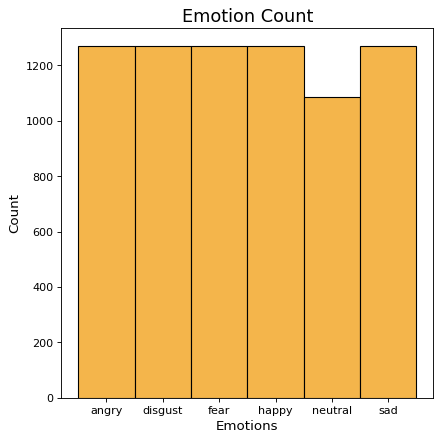

In [5]:
# counting audio categorized by emotions
plt.figure(figsize=(6,6), dpi=80)
plt.title("Emotion Count", size=16)
plt.xlabel('Emotions', size = 12)
plt.ylabel('Count', size = 12)
sns.histplot(dataset.Emotions, color='#F19C0E')

In [6]:
dataset

,Path,Emotions
0,./dataset/1001_DFA_ANG_XX.wav,angry
1,./dataset/1001_DFA_DIS_XX.wav,disgust
2,./dataset/1001_DFA_FEA_XX.wav,fear
3,./dataset/1001_DFA_HAP_XX.wav,happy
4,./dataset/1001_DFA_NEU_XX.wav,neutral
...,...,...
7437,./dataset/1091_WSI_DIS_XX.wav,disgust
7438,./dataset/1091_WSI_FEA_XX.wav,fear
7439,./dataset/1091_WSI_HAP_XX.wav,happy
7440,./dataset/1091_WSI_NEU_XX.wav,neutral


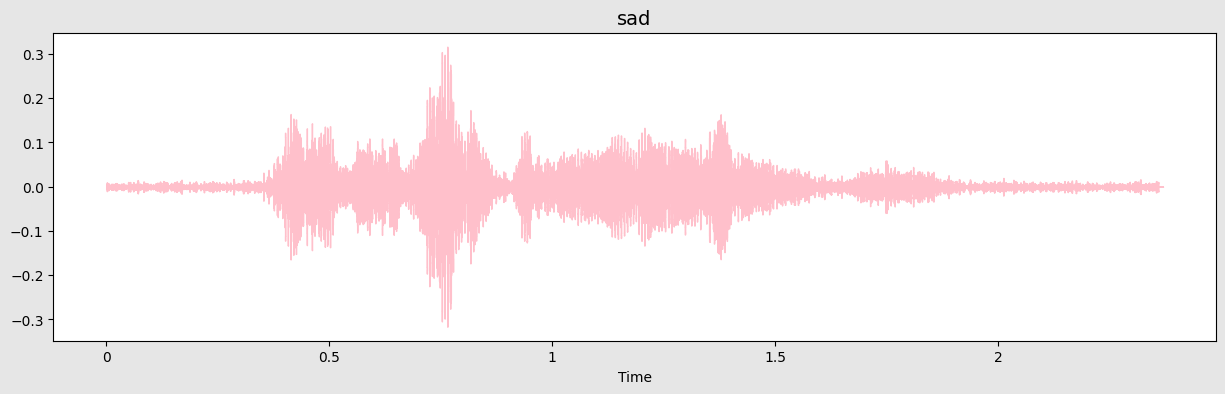

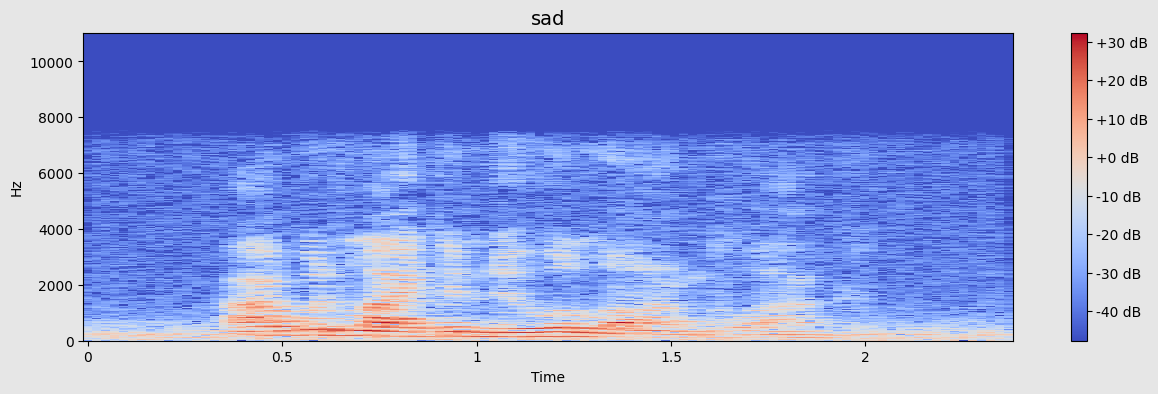

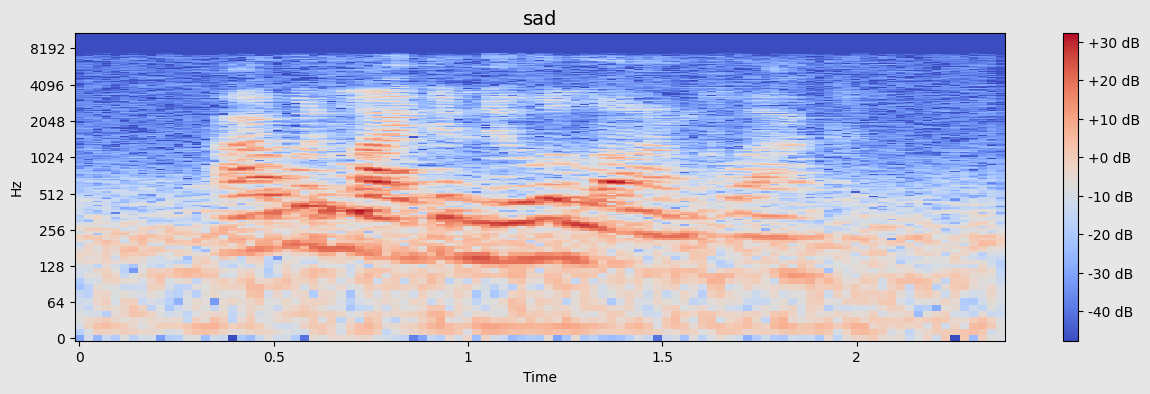

In [116]:
emotion = "sad"
path = list(dataset["Path"][dataset["Emotions"] == emotion])
idx = random.randint(0, len(path))

data,sampling_rate = librosa.load(path[idx])
waveplot(data,sampling_rate,emotion)
spectogram_linear(data,sampling_rate,emotion)
spectogram_log(data,sampling_rate,emotion)
Audio(path[idx])

In [150]:

# load an individual sample audio file
# read the full 3 seconds of the file, cut off the first 0.5s of silence; native sample rate = 48k
# don't need to store the sample rate that librosa.load returns
file = "./dataset/1001_DFA_FEA_XX.wav"
music_array, sample_rate = librosa.load(file, sr=44100)

# Feature Extraction

In [6]:
file = dataset["Path"][0]
mfcc_feature(file)

array([-493.19052  ,  130.57959  ,  -15.17191  ,   47.93188  ,
         -2.633088 ,   17.580477 ,  -22.392756 ,   -7.491928 ,
        -10.839611 ,   -5.1909175,   -9.13411  ,   -3.39687  ,
          2.2448757], dtype=float32)

In [216]:
X_mfcc = dataset["Path"].apply(lambda x: mfcc_feature(x))

In [231]:
X = [item for item in X_mfcc]
X = np.array(X)
# X = np.expand_dims(X, -1)
X.shape

(7442, 13)

In [232]:
y = dataset["Emotions"]

In [233]:
extracted_audio = pd.DataFrame(X)
extracted_audio["Emotions"] = y
extracted_audio

,0,1,2,3,4,5,6,7,8,9,10,11,12,Emotions
0,-493.190521,130.579590,-15.171910,47.931881,-2.633088,17.580477,-22.392756,-7.491928,-10.839611,-5.190917,-9.134110,-3.396870,2.244876,angry
1,-533.953247,136.550781,-23.712204,57.036129,2.207755,23.590717,-24.639025,3.642645,-11.085177,-6.580270,-4.861051,-5.963374,5.484548,disgust
2,-480.136627,111.516022,-8.318337,35.844154,5.748573,10.552864,-19.095610,-3.668406,-7.424833,-7.283167,-10.904288,-5.082917,0.080815,fear
3,-504.650818,122.550156,-15.159066,45.422527,7.672544,13.340709,-25.357574,-2.860527,-7.579400,-9.865721,-12.854387,-5.120391,0.348238,happy
4,-533.270813,128.219086,-6.071215,42.160110,10.969781,13.633672,-14.749569,-5.942591,-9.058737,-7.911500,-7.507226,-2.613515,0.558189,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,-617.730042,134.337433,10.402402,54.559120,-14.122120,40.434372,-16.255671,8.739514,-8.622474,2.713698,1.193010,-11.110655,6.110638,disgust
7438,-619.640259,128.407333,8.628220,64.150795,-14.054352,45.616741,-18.352726,8.310579,-5.797090,2.402461,-2.037600,-12.133834,5.760205,fear
7439,-549.675659,129.427277,-0.508095,57.266365,-16.252283,28.453440,-23.715984,5.575493,-11.502940,3.809773,-2.094521,-10.209229,8.525149,happy
7440,-575.136841,127.776810,13.419468,46.244183,-18.300213,30.528986,-12.969846,4.706892,-8.582385,4.726083,-0.939862,-9.744591,4.713840,neutral


# SVM Model

In [237]:
label_encoder = LabelEncoder()
# 0:"angry", 1:"disgust", 2:"fear", 3:"happy", 4:"neutral", 5:"sad"
extracted_audio['Emotions'] = label_encoder.fit_transform(extracted_audio['Emotions'])

X = extracted_audio.drop(labels='Emotions', axis= 1)
Y = extracted_audio['Emotions']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

scaler = StandardScaler()
x_train = scaler.fit_transform(X_train)
x_test = scaler.transform(X_test)

In [209]:
mlp_model = MLPClassifier(activation='relu',
                         solver='sgd',
                         hidden_layer_sizes=100,
                         alpha=0.839903176695813,
                         batch_size=150,
                         learning_rate='adaptive',
                         max_iter=100000)
# Fitting mlp model
mlp_model.fit(x_train,y_train)

MLPClassifier(alpha=0.839903176695813, batch_size=150, hidden_layer_sizes=100,
              learning_rate='adaptive', max_iter=100000, solver='sgd')

In [211]:
y_pred = mlp_model.predict(x_test)
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

print("\nModel:{}    Accuracy: {:.2f}%".format(type(mlp_model).__name__ , accuracy*100))


Model:MLPClassifier    Accuracy: 49.23%


In [246]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=2)
grid.fit(x_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  19.4s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  17.9s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  21.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  20.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  19.2s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   1.0s
[CV] END .....................C=0.1, gamma=1, k

In [1]:
print(grid.best_estimator_)

NameError: name 'grid' is not defined

In [212]:
SVM_model = svm.SVC(kernel='linear')
SVM_model.fit(x_train, y_train)

filename = 'SVM_Model.sav'
pickle.dump(SVM_model, open(filename, 'wb'))

SVC(kernel='linear')

In [213]:
y_pred=SVM_model.predict(x_test)

report = classification_report(y_test, y_pred)
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

print("\nModel:{}    Accuracy: {:.2f}%".format(type(SVM_model).__name__ , accuracy*100))
print(report)


Model:SVC    Accuracy: 42.04%


In [ ]:
print("The Model's Prediction ")
print("<<<===========================================>>>")
df = pd.DataFrame({'Actual': y_test, 'Predict': y_pred})
df